In [1]:
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cdlib
import math

In [2]:
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))

    def find(self, node):
        if self.parent[node] != node:
            self.parent[node] = self.find(self.parent[node])  # Path compression
        return self.parent[node]

    def union(self, node1, node2):
        root1 = self.find(node1)
        root2 = self.find(node2)
        if root1 != root2:
            self.parent[root2] = root1  # Union

In [3]:
class EstrategiaEvolutiva():
        
    def __init__(self, graph, N=100, init=0.5, pcross=0.7, pmut=0.1, n_iter=1000, fitness_metrics=1, n_tour = 4, crossover_op=2):
        self.graph = graph # Grafo
        self.N = N # Tamaño de la población
        self.pop = [] # Población
        self.init = init # Ponderación de la inicialización
        self.pcross = pcross # Probabilidad de cruce
        self.pmut = pmut # Probabilidad de mutación
        self.n_iter = n_iter # Numero de iteraciones
        self.fitness_metrics = fitness_metrics # Par de métricas utilizadas para el fitness
        self.n_tour = n_tour # Número de participantes en el torneo
        self.crossover_op = crossover_op # Operador de cruce

    def __choose_with_prob(self, prob):
        if random.random() <= prob:
            return True
        return False
	
    def random_init(self) -> list[int]:
        """ Inicializa individuo de forma aleatoria """

        graph_label = [-1] * len(self.graph.nodes())
        for node in list(self.graph.nodes()):
            neighbors = list(self.graph.neighbors(node))
            if len(neighbors) == 0:
                graph_label[node] = node
            else:
                graph_label[node] = random.choice(neighbors)

        return graph_label

    def label_propagation_init(self) -> list[int]:
        """ Inicializa un individuo mediante el algoritmo de propagación de etiquetas """

        # Se obtienen las comunidades mediante el algoritmo de propagación de etiquetas
        community_dict_values = nx.algorithms.community.asyn_lpa_communities(self.graph)

        # Se crea un mapping de nodos a comunidades
        node_community_map = {}
        for community_id, nodes in enumerate(community_dict_values):
            for node in nodes:
                node_community_map[node] = community_id

        locus_representation = [-1] * len(self.graph.nodes()) 
        
        # Para cada nodo se asigna un nodo vecino de la misma comunidad
        for node in self.graph.nodes():
            community = node_community_map[node] 
            same_community_neighbors = [neighbor for neighbor in self.graph.neighbors(node) if node_community_map[neighbor] == community]
            if same_community_neighbors:
                locus_representation[node] = random.choice(same_community_neighbors)
            else:
                locus_representation[node] = node

        return locus_representation

    def create_pop(self):
        """ Crea una población de N individuos codificados en modo locus """

        random_pop = math.ceil(self.N*self.init)
        label_propagation_pop = self.N - random_pop
        
        # Se inicializa la población con individuos aleatorios
        for _ in range(random_pop):
            self.pop.append(self.random_init()) 
        # Se inicializa el resto de la población mediante el algoritmo de propagación de etiquetas
        for _ in range(label_propagation_pop):
            self.pop.append(self.label_propagation_init())

    def decode(self, locus_representation: list[int]) -> dict[int, int]:
        """ Decodifica un individuo en modo locus a modo cluster """
        uf = UnionFind(len(locus_representation))

        for node, neighbor in enumerate(locus_representation):
            uf.union(node, neighbor)

        # Agrupar nodos por su raíz en la estructura Union-Find
        communities = {}
        for node in range(len(locus_representation)):
            root = uf.find(node)
            if root not in communities:
                communities[root] = []
            communities[root].append(node)

        communities = list(communities.values())

        return communities
    
    def plot(self, node_community_map: list[list[int]]):
        """ Pinta el grafo con un color por comunidad """

        # Se crea un mapping de nodos a comunidades
        node_color_map = {}
        for idx, community in enumerate(node_community_map):
            for node in community:
                node_color_map[node] = idx

        # Se obtiene la lista de colores        
        color_map = []
        for node in self.graph.nodes():
            color_map.append(node_color_map[node])

        plt.figure(figsize=(30, 25))
        nx.draw(self.graph, node_color=color_map, with_labels=True)      
        plt.show()

    def plot_pareto_front(self, first_front, fitness_values):
        """ Pinta el frente de Pareto """
        # Extraer los valores de fitness para los individuos en el primer frente
        x_values = [fitness_values[i][0] for i in first_front]
        y_values = [fitness_values[i][1] for i in first_front]

        # Crear el plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x_values, y_values, c='blue', marker='o')
        plt.title("Frente de Pareto")
        plt.xlabel("Objetivo 1")
        plt.ylabel("Objetivo 2")
        plt.grid(True)
        plt.show()
    
    def fitness(self, individual: list[int]) -> float:
        """ Calcula el fitness de un individuo

        0: {Community score+, Internal density}
        1: {Q +, Internal density +}
        2: {Community score+, Average-ODF}
        3: {Community score+, Max-ODF}

        """
        
        communities = self.decode(individual)

        NodeClustering = cdlib.NodeClustering(communities, self.graph)
        NodeClusteringCommunities = [cdlib.NodeClustering([community], self.graph) for community in communities]

        if self.fitness_metrics == 0:
            community_score = sum(cdlib.evaluation.average_internal_degree(self.graph, NodeClustering, summary=False))
            internal_density = sum(1 - cdlib.evaluation.internal_edge_density(self.graph, community).score for community in NodeClusteringCommunities)
            return [community_score, internal_density]
        
        elif self.fitness_metrics == 1:
            q = cdlib.evaluation.newman_girvan_modularity(self.graph, NodeClustering).score
            internal_density = sum(1 - cdlib.evaluation.internal_edge_density(self.graph, community).score for community in NodeClusteringCommunities)
            return [q, internal_density]
        
        elif self.fitness_metrics == 2:
            avg_odf = sum(cdlib.evaluation.avg_odf(self.graph, community).score for community in NodeClusteringCommunities)
            community_score = sum(cdlib.evaluation.average_internal_degree(self.graph, NodeClustering, summary=False))
            return [community_score, avg_odf]
        
        elif self.fitness_metrics == 3:
            max_odf = sum(cdlib.evaluation.max_odf(self.graph, community).score for community in NodeClusteringCommunities)
            community_score = sum(cdlib.evaluation.average_internal_degree(self.graph, NodeClustering, summary=False))
            return (community_score, max_odf)
        
    def dominates(self, individual1:float, individual2:float) -> bool:
        """ Devuelve True si individual1 domina a individual2 """
        return all(x >= y for x, y in zip(individual1, individual2)) and any(x > y for x, y in zip(individual1, individual2))
    
    def fast_non_dominated_sort(self, fitness:list[float]) -> list[list[int]]:
        """ Devuelve una lista de frentes de Pareto """
        domination_counts = [0] * len(self.pop)
        dominated_solutions = [set() for _ in self.pop]
        fronts = [[]]

        for p in range(len(fitness)):
            for q in range(len(fitness)):
                if p != q:
                    if self.dominates(fitness[p], fitness[q]):
                        dominated_solutions[p].add(q)
                    elif self.dominates(fitness[q], fitness[p]):
                        domination_counts[p] += 1

            if domination_counts[p] == 0:
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated_solutions[p]:
                    domination_counts[q] -= 1
                    if domination_counts[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]
    
    def crowding_distance(self, front: list[int], fitness_values:list[float]) -> list[int]:
        """ Calcula la crowding distance de un frente y devuelve los indices ordenados por crowding distance """

        distances = [0] * len(front)
        
        if len(front) < 2:
            return front  # Si hay menos de 2 individuos, no se puede calcular la distancia

        # Calcular la distancia de aglomeración para cada individuo
        for i in range(2):
            sorted_front = sorted(front, key=lambda x: fitness_values[x][i])
            max_value = max(fitness_values[x][i] for x in front)
            min_value = min(fitness_values[x][i] for x in front)

            distances[front.index(sorted_front[0])] = float('inf')
            distances[front.index(sorted_front[-1])] = float('inf')

            if max_value == min_value:
                continue

            for k in range(1, len(front) - 1):
                distance = (fitness_values[sorted_front[k + 1]][i] - fitness_values[sorted_front[k - 1]][i]) / (max_value - min_value)
                distances[front.index(sorted_front[k])] += distance

        # Ordenar los individuos por su distancia de aglomeración en orden descendente
        sorted_indices = sorted(range(len(front)), key=lambda x: distances[x], reverse=True)

        return [front[i] for i in sorted_indices]

    def tournament(self, old_fitness):
        """ Selección de padres por torneo """
        participants = random.sample(self.pop, self.n_tour)
        best = None
        for participant in participants:
            if best is None:
                best = participant
            elif self.dominates(old_fitness[self.pop.index(participant)], old_fitness[self.pop.index(best)]):
                best = participant
        return best
    
    def single_point_crossover(self, p1, p2):
        """ Crossover de un punto """
        c1, c2 = p1.copy(), p2.copy()
        
        if np.random.uniform() < self.pcross:
            # seleccionar punto de crossover
            pt = random.randint(1, len(p1)-2)
            c1 = p1[:pt] + p2[pt:]
            c2 = p2[:pt] + p1[pt:]
        return [c1, c2]
    
    def multiple_point_crossover(self, p1, p2, k):
        """ Crossover de k puntos """

        if len(p1) != len(p2):
            raise ValueError("Los padres deben tener el mismo tamaño")

        # Generar k puntos de cruce únicos
        crossover_points = sorted(random.sample(range(1, len(p1)), k))
        offspring1, offspring2 = [], []
        previous_point = 0
        for i, point in enumerate(crossover_points):
            if i % 2 == 0:
                offspring1.extend(p1[previous_point:point])
                offspring2.extend(p2[previous_point:point])
            else:
                offspring1.extend(p2[previous_point:point])
                offspring2.extend(p1[previous_point:point])
            previous_point = point

        # Agregar el último segmento
        if k % 2 == 0:
            offspring1.extend(p1[previous_point:])
            offspring2.extend(p2[previous_point:])
        else:
            offspring1.extend(p2[previous_point:])
            offspring2.extend(p1[previous_point:])
        return [offspring1, offspring2]

    def uniform_crossover(self, p1,p2):
        """ Crossover uniforme """
        c1, c2 = p1.copy(), p2.copy()
        if np.random.uniform() < self.pcross:
            for i in range(len(p1)):
                if random.randint(0,2) == 1:
                    c1[i] , c2[i] = c2[i] , c1[i]
        return [c1,c2]
    
    def crossover(self, i1, i2):
        """ Cruce de dos individuos """
        if self.crossover_op==0:
            return self.single_point_crossover(i1,i2)
        elif self.crossover_op==1:
            return self.multiple_point_crossover(i1,i2,2)
        elif self.crossover_op==2:
            return self.uniform_crossover(i1,i2)

    def mutate(self, individual: list) -> list[int]:
        """ Mutación de un individuo """
        size = len(individual)
        # Se muta cada nodo con probabilidad pmut cambiando el vecino por uno aleatorio
        for i in range(size):
            if self.__choose_with_prob(self.pmut):
                neighbors = list(self.graph.neighbors(i))
                individual[i] = random.choice(neighbors)

        return individual
    
    def create_children(self, old_fitness):
        children = []
        while len(children) < self.N:
            parent1 = self.tournament(old_fitness)
            parent2 = parent1
            while parent1 == parent2:
                parent2 = self.tournament(old_fitness)
            child1, child2 = self.crossover(parent1, parent2)

            self.mutate(child1)
            self.mutate(child2)

            children.append(child1)
            children.append(child2)

        return children

    def evolve(self):
        """ Evoluciona la población durante n_iter iteraciones """
        
        self.create_pop() 
        with ProcessPoolExecutor() as executor:
                old_fitness = list(executor.map(self.fitness, self.pop))

        for _ in range(self.n_iter): 
            
            # Se añaden los hijos a la población
            children = self.create_children(old_fitness)
            self.pop.extend(children)

            # Se calcula el fitness de la población y se calculan los frentes de Pareto
            with ProcessPoolExecutor() as executor:
                new_fitness = list(executor.map(self.fitness, children))
            
            fitness_pop = old_fitness + new_fitness
            
            paretos = self.fast_non_dominated_sort(fitness_pop)
            
            # Se seleccionan los individuos que pasan a la siguiente generación
            next_gen = []
            old_fitness = []
            for front in paretos:
                if len(next_gen) + len(front) > self.N:
                    crowding_distances = self.crowding_distance(front, fitness_pop)
                    for i in range(self.N - len(next_gen)):
                        next_gen.append(self.pop[crowding_distances[i]])
                        old_fitness.append(fitness_pop[crowding_distances[i]])
                    break
                next_gen.extend([self.pop[i] for i in front])
                old_fitness.extend([fitness_pop[i] for i in front])


            self.pop = next_gen

            if _ % 100 == 0:
                print(f"Generación {_}")
                self.plot_pareto_front(paretos[0], fitness_pop) 

In [4]:
"""
import networkx as nx

# Crear un grafo con 15 nodos y 23 conexiones
graph = nx.gnm_random_graph(13, 16)
"""

'\nimport networkx as nx\n\n# Crear un grafo con 15 nodos y 23 conexiones\ngraph = nx.gnm_random_graph(13, 16)\n'

In [5]:
# Carga del grafo
graph = nx.read_graphml("data/amazon_graph.graphml")

# Renombramos los nodos al rango [0, N]
mapping = {node: i for i, node in enumerate(graph.nodes())}
graph = nx.relabel_nodes(graph, mapping)


Generación 0


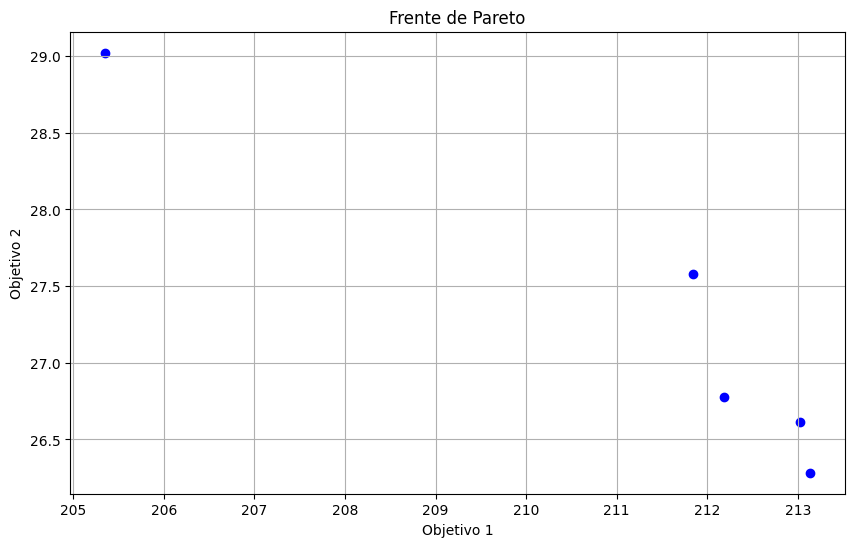

Generación 100


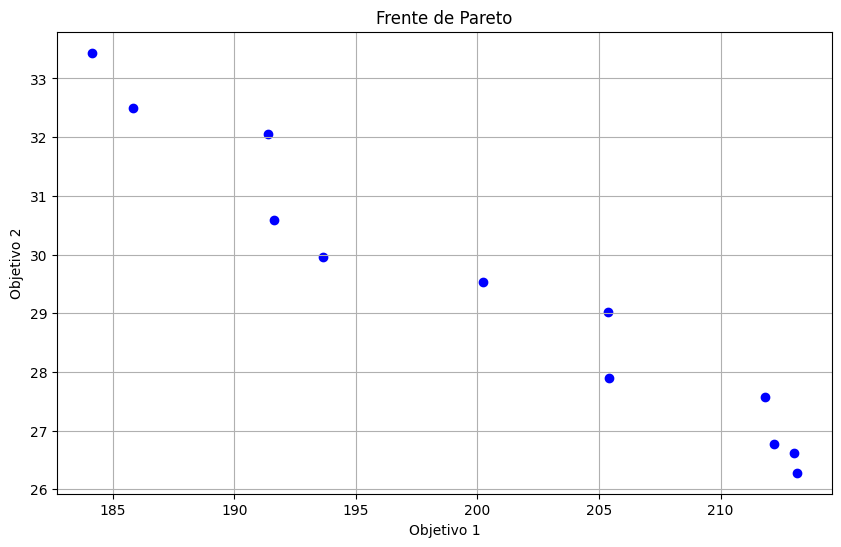

Generación 200


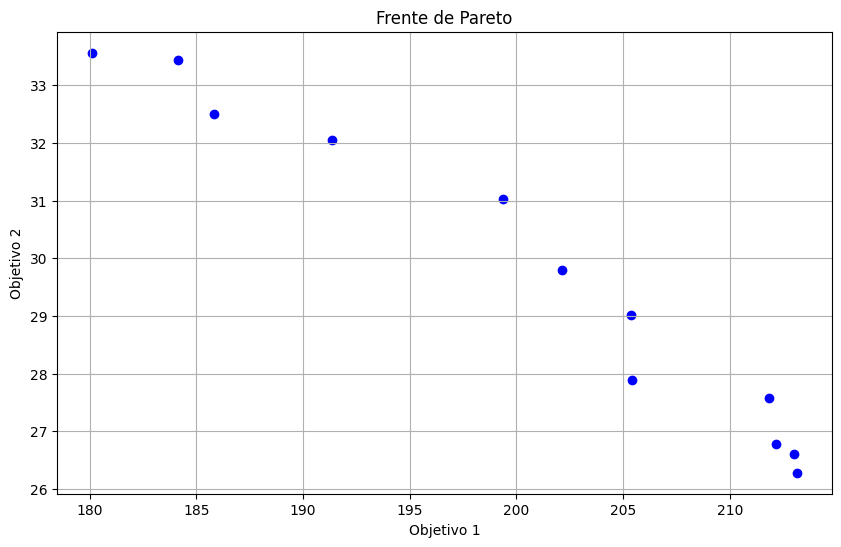

Generación 300


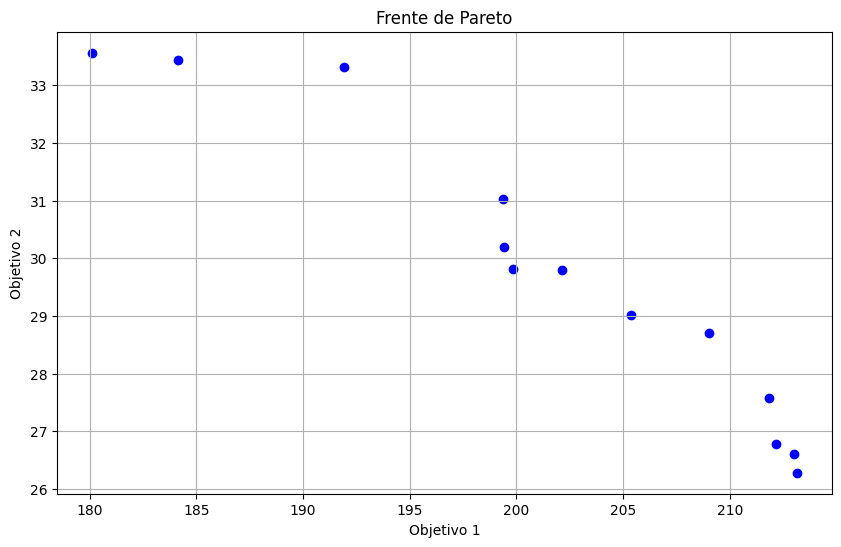

Generación 400


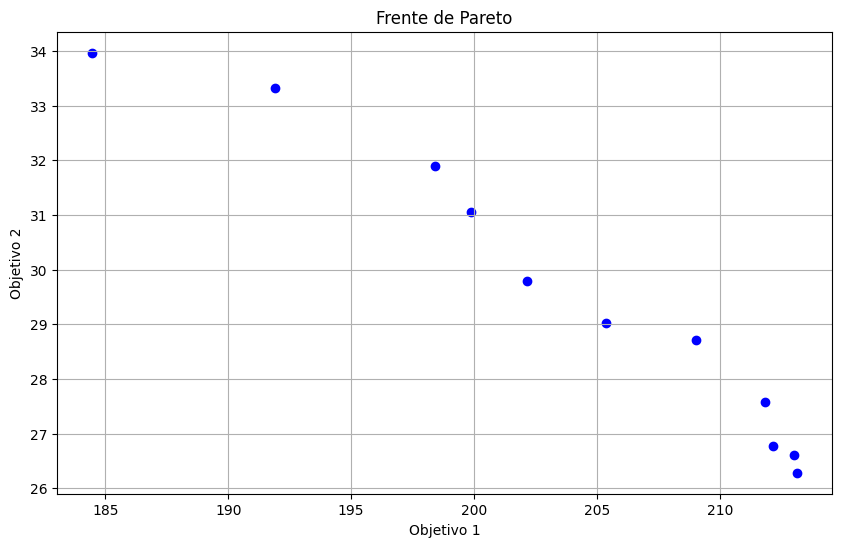

Generación 500


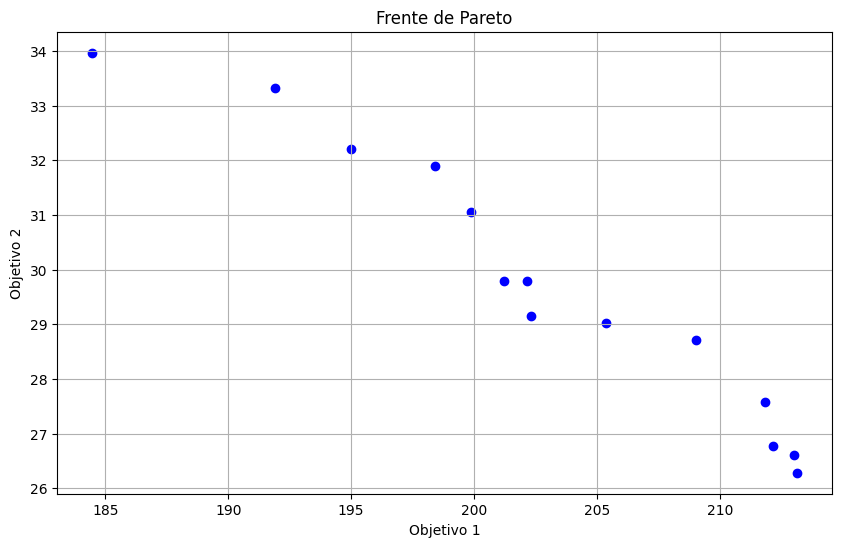

Generación 600


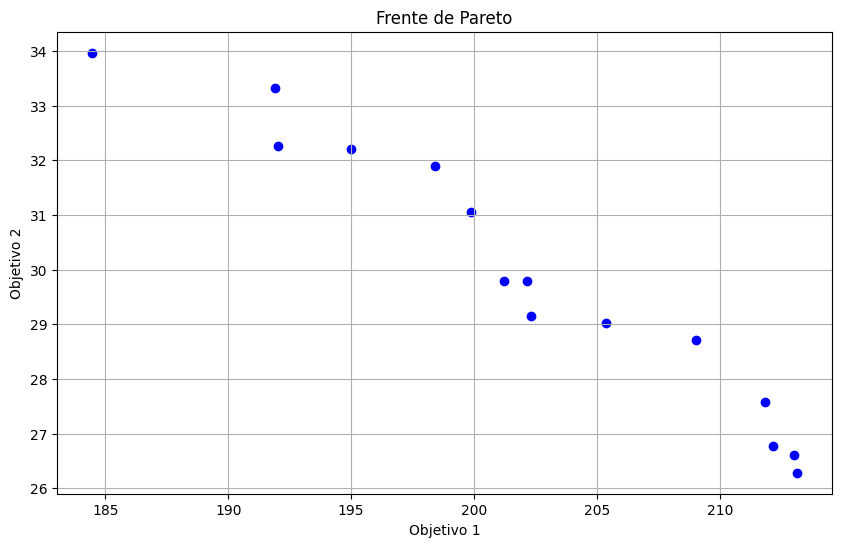

Generación 700


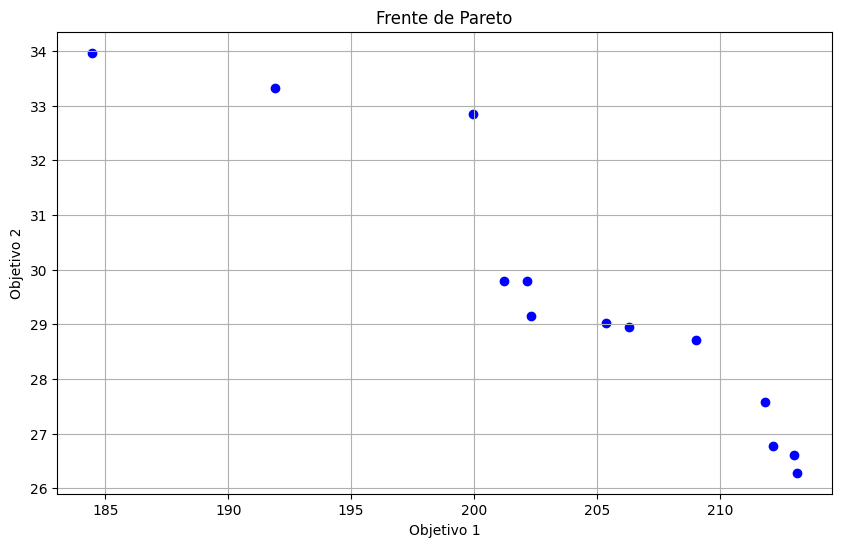

Generación 800


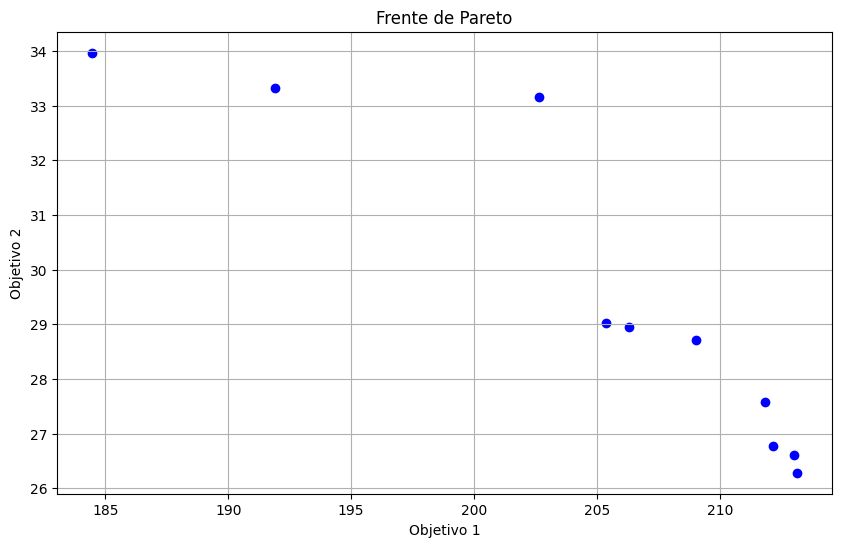

Generación 900


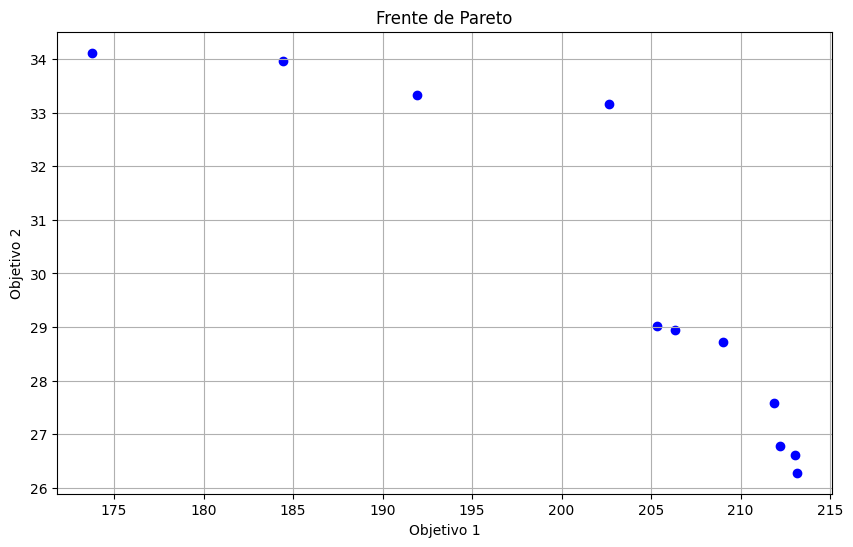

In [6]:
es = EstrategiaEvolutiva(graph, N=100, init=0.5, pcross=0.5, pmut=0.3, n_iter=1000, fitness_metrics=0, n_tour=4, crossover_op=2)
es.evolve()

### Plot con inicialización de individuo

In [7]:
"""es = EstrategiaEvolutiva(graph, N=100, pcross=0, pmut=0.3, n_iter=1000, elitism=0)
lb = es.label_propagation_init()
#lb = es.random_init()
communities = es.decode(lb)
es.plot(communities)
print(communities)
a, b, c, d = es.fitness(lb)"""

'es = EstrategiaEvolutiva(graph, N=100, pcross=0, pmut=0.3, n_iter=1000, elitism=0)\nlb = es.label_propagation_init()\n#lb = es.random_init()\ncommunities = es.decode(lb)\nes.plot(communities)\nprint(communities)\na, b, c, d = es.fitness(lb)'

### Plot con ground truth

In [8]:
"""plt.figure(figsize=(30, 25))
nx.draw(graph, node_color=[data['community'] for _, data in graph.nodes(data=True)], with_labels=True)
plt.show()"""

"plt.figure(figsize=(30, 25))\nnx.draw(graph, node_color=[data['community'] for _, data in graph.nodes(data=True)], with_labels=True)\nplt.show()"